Un ejemplo completo de procesamiento de datos en Pandas--- 10:49 min
===

* Última modificación: Mayo 6, 2022 | [YouTube](https://youtu.be/AOh17tsJ1m4)

In [1]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import tensorflow as tf

Carga y preparación de datos
---

In [2]:
import pandas as pd

SHUFFLE_BUFFER = 500
BATCH_SIZE = 2

csv_file = tf.keras.utils.get_file(
    "heart.csv",
    "https://storage.googleapis.com/download.tensorflow.org/data/heart.csv",
)

In [3]:
df = pd.read_csv(csv_file)
target = df.pop("target")
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal


In [4]:
numeric_feature_names = [
    "age",
    "thalach",
    "trestbps",
    "chol",
    "oldpeak",
]
numeric_features = df[numeric_feature_names]
numeric_features.head()

,age,thalach,trestbps,chol,oldpeak
0,63,150,145,233,2.3
1,67,108,160,286,1.5
2,67,129,120,229,2.6
3,37,187,130,250,3.5
4,41,172,130,204,1.4


Asignación del tipo de característica
---

In [5]:
binary_feature_names = ["sex", "fbs", "exang"]

In [6]:
categorical_feature_names = ["cp", "restecg", "slope", "thal", "ca"]

In [7]:
inputs = {}
for name, column in df.items():
    if type(column[0]) == str:
        dtype = tf.string
    elif name in categorical_feature_names or name in binary_feature_names:
        dtype = tf.int64
    else:
        dtype = tf.float32

    inputs[name] = tf.keras.Input(shape=(), name=name, dtype=dtype)

inputs

{'age': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'age')>,
 'sex': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'sex')>,
 'cp': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'cp')>,
 'trestbps': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'trestbps')>,
 'chol': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'chol')>,
 'fbs': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'fbs')>,
 'restecg': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'restecg')>,
 'thalach': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'thalach')>,
 'exang': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'exang')>,
 'oldpeak': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'oldpeak')>,
 'slope': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'slope')>,
 'ca': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'ca')>,
 'thal': <KerasTensor: shape=(None,) dtype=string 

Procesamiento de entradas binarias
---

In [8]:
#
# Entradas binarias
#
preprocessed = []

for name in binary_feature_names:
    inp = inputs[name]
    inp = inp[:, tf.newaxis]
    float_value = tf.cast(inp, tf.float32)
    preprocessed.append(float_value)

preprocessed

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_1')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_2')>]

Procesamiento de entradas numéricas
---

In [9]:
def stack_dict(inputs, fun=tf.stack):
    values = []
    for key in sorted(inputs.keys()):
        values.append(tf.cast(inputs[key], tf.float32))

    return fun(values, axis=-1)

In [10]:
#
# Entradas numéricas
#
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(stack_dict(dict(numeric_features)))

numeric_inputs = {}
for name in numeric_feature_names:
    numeric_inputs[name] = inputs[name]

numeric_inputs = stack_dict(numeric_inputs)
numeric_normalized = normalizer(numeric_inputs)

preprocessed.append(numeric_normalized)

preprocessed

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_1')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_2')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'normalization')>]

Entradas categóricas
---

In [11]:
#
# Entradas categóricas
#
for name in categorical_feature_names:
    vocab = sorted(set(df[name]))
    print(f"name: {name}")
    print(f"vocab: {vocab}\n")

    if type(vocab[0]) is str:
        lookup = tf.keras.layers.StringLookup(vocabulary=vocab, output_mode="one_hot")
    else:
        lookup = tf.keras.layers.IntegerLookup(vocabulary=vocab, output_mode="one_hot")

    x = inputs[name][:, tf.newaxis]
    x = lookup(x)
    preprocessed.append(x)

name: cp
vocab: [0, 1, 2, 3, 4]

name: restecg
vocab: [0, 1, 2]

name: slope
vocab: [1, 2, 3]

name: thal
vocab: ['1', '2', 'fixed', 'normal', 'reversible']

name: ca
vocab: [0, 1, 2, 3]



Ensamble de la cabeza de preprocesamiento
---

In [12]:
#
# Capa de preprocesamiento final
#
preprocessed

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_1')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_2')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'normalization')>,
 <KerasTensor: shape=(None, 6) dtype=float32 (created by layer 'integer_lookup')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'integer_lookup_1')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'integer_lookup_2')>,
 <KerasTensor: shape=(None, 6) dtype=float32 (created by layer 'string_lookup')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'integer_lookup_3')>]

In [13]:
#
# Concatenacion en un solo tensor
#
preprocesssed_result = tf.concat(preprocessed, axis=-1)
preprocesssed_result

<KerasTensor: shape=(None, 33) dtype=float32 (created by layer 'tf.concat')>

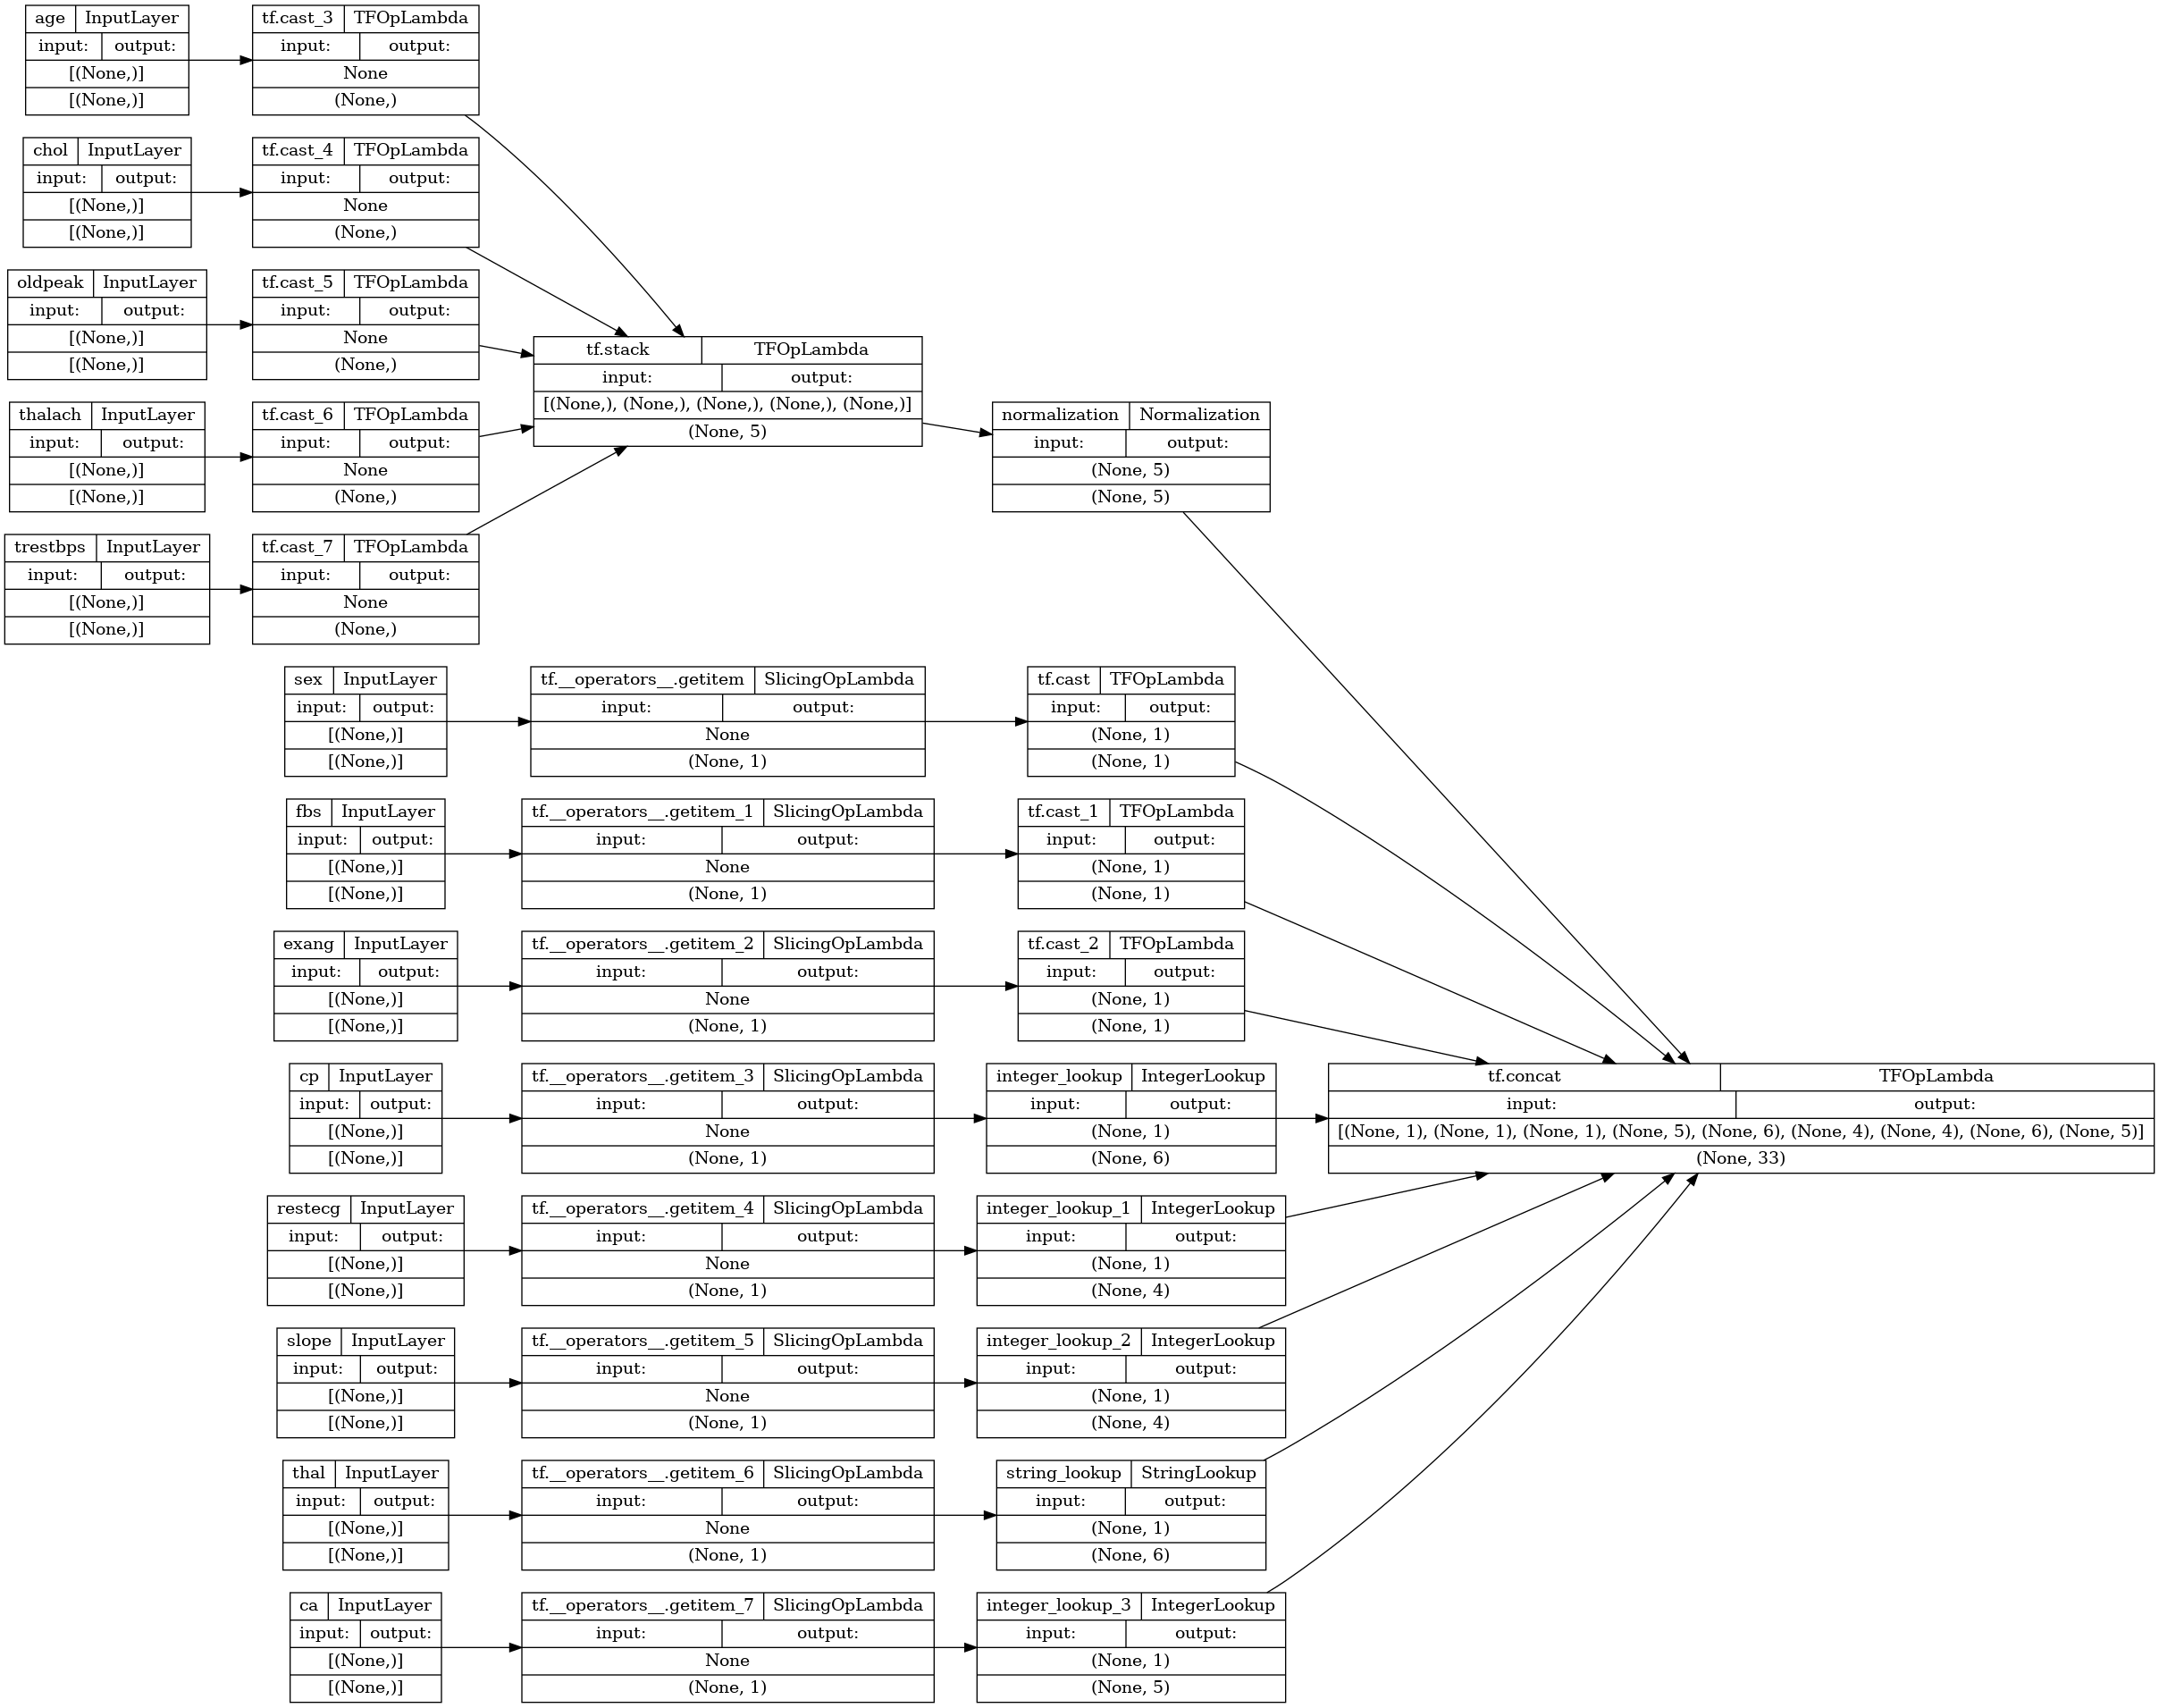

In [14]:
#
# Modelo para preprocesamiento que puede ser reutilizado
#
preprocessor = tf.keras.Model(inputs, preprocesssed_result)

tf.keras.utils.plot_model(preprocessor, rankdir="LR", show_shapes=True)

Creación del modelo
---

In [15]:
body = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1),
    ]
)

In [16]:
inputs

{'age': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'age')>,
 'sex': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'sex')>,
 'cp': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'cp')>,
 'trestbps': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'trestbps')>,
 'chol': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'chol')>,
 'fbs': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'fbs')>,
 'restecg': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'restecg')>,
 'thalach': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'thalach')>,
 'exang': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'exang')>,
 'oldpeak': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'oldpeak')>,
 'slope': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'slope')>,
 'ca': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'ca')>,
 'thal': <KerasTensor: shape=(None,) dtype=string 

In [17]:
x = preprocessor(inputs)
x

<KerasTensor: shape=(None, 33) dtype=float32 (created by layer 'model')>

In [18]:
result = body(x)
result

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'sequential')>

In [19]:
#
# Este modelo espera un diccionario de entradas
#
model = tf.keras.Model(inputs, result)

model.compile(
    optimizer="adam",
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [20]:
history = model.fit(
    #
    # Se convierte el DataFrame a un diccionario de entradas
    #
    dict(df),
    target,
    epochs=5,
    batch_size=BATCH_SIZE,
)

Epoch 1/5
152/152 [==============================] - 1s 3ms/step - loss: 0.6564 - accuracy: 0.7228
Epoch 2/5
152/152 [==============================] - 0s 3ms/step - loss: 0.5108 - accuracy: 0.7327
Epoch 3/5
152/152 [==============================] - 0s 3ms/step - loss: 0.3963 - accuracy: 0.7657
Epoch 4/5
152/152 [==============================] - 0s 3ms/step - loss: 0.3418 - accuracy: 0.8185
Epoch 5/5
152/152 [==============================] - 1s 3ms/step - loss: 0.3109 - accuracy: 0.8185


In [21]:
#
# Tambien es posible usar tf.data
#
ds = tf.data.Dataset.from_tensor_slices((dict(df), target))

ds = ds.batch(BATCH_SIZE)

history = model.fit(ds, epochs=5)

Epoch 1/5
152/152 [==============================] - 1s 5ms/step - loss: 0.2928 - accuracy: 0.8548
Epoch 2/5
152/152 [==============================] - 1s 5ms/step - loss: 0.2795 - accuracy: 0.8548
Epoch 3/5
152/152 [==============================] - 1s 5ms/step - loss: 0.2683 - accuracy: 0.8614
Epoch 4/5
152/152 [==============================] - 1s 5ms/step - loss: 0.2603 - accuracy: 0.8647
Epoch 5/5
152/152 [==============================] - 1s 5ms/step - loss: 0.2527 - accuracy: 0.8680
